In [2]:
# activate conda environment
# conda activate cellpose
# the version is 3.8.12

In [1]:
import os
import subprocess
from cellpose import models, io
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [6]:
def crop_roi(path_img, path_mask, path_outdir, size=80):
    #画像の読み込み
    cv2_img = cv2.imread(path_img)
    cv2_mask = cv2.imread(path_mask, cv2.IMREAD_UNCHANGED)
    lower_limit = 1
    upper_limit = 255
    for threshold in range(lower_limit, upper_limit):
        mask = cv2.inRange(cv2_mask, threshold, threshold)
        if mask.sum() == 0:
            continue
        else:
            binary_image = mask.astype(np.uint8)
            contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for index, contour in enumerate(contours):
                # # ROIを作成
                # x, y, w, h = cv2.boundingRect(contour)
                # roi = cv2_img[y:y+h, x:x+w]

                # ROIの重心を計算
                # 輪郭が存在するか確認
                M = cv2.moments(contour)
                if M['m00'] == 0:
                    continue    
                else:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])

                # 重心から+/- 100 ピクセルの正方形領域を切り抜く
                size = size
                height, width, _ = cv2_img.shape
                crop_region = cv2_img[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                

                
                # 切り抜いた領域を保存などの処理
                basename_img = os.path.basename(path_img).split(".")[0]
                output_path = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region.png"
                cv2.imwrite(os.path.join(path_outdir, output_path), crop_region)
                print("Cropped image is:", output_path)
                
                # gray scaleの画像も保存する
                cv2_img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
                crop_region_gray = cv2_img_gray[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                output_path_gray = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region_gray.png"
                cv2.imwrite(os.path.join(path_outdir, output_path_gray), crop_region_gray)
                print("Cropped gray image is:", output_path_gray)

In [7]:
# 明視野画像のあるディレクトリのパスを指定
dir_subdir = "Project001_YSIY1447"

dir_date_meta = "20240206_thunder_Sporulation_Cdc3-intEnvy"

path_to_indir = os.path.join("/mnt/g", dir_date_meta, dir_subdir)

path_to_oudir = os.path.join(path_to_indir, "cellpose_segmentation")
if not os.path.exists(path_to_oudir):
    os.makedirs(path_to_oudir)

# path_to_model = "cyto"
model = models.CellposeModel(model_type='cyto', gpu=True)

# model_path = "/mnt/d/200_GitHub_Repository/cellpose_segmentation/CP_20231220_180112_segspo"
# model = models.CellposeModel(pretrained_model=model_path, gpu=True)

In [57]:
imgs = []
path_to_indir = path_to_indir
list_of_imgs = glob(os.path.join(path_to_indir, "Image*_ch00.tif"))
list_of_imgs.sort()
num_of_imgs = len(list_of_imgs)

for img_path in list_of_imgs:
    imgs.append(io.imread(filename=img_path))
    
    
result = model.eval(x=imgs,
                    diameter=120,
                    channels=[0, 0],)

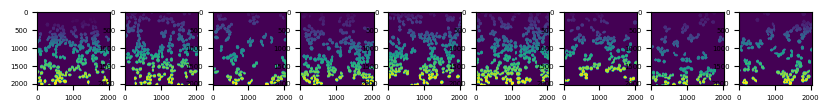

In [59]:
fig, axs = [],[]
fig, axs = plt.subplots(1,num_of_imgs, figsize=(10,10))
plt.rcParams["font.size"] =5
for i in range(num_of_imgs):
    axs[i].imshow(result[0][i])

In [60]:
for i in range(num_of_imgs):
    file_name = os.path.basename(list_of_imgs[i]).split(".")[0]
    io.masks_flows_to_seg(images=imgs[i], masks=result[0][i], 
                          flows=result[1][i], 
                          diams=None, 
                          file_names=os.path.join(path_to_oudir, file_name)
    )
    
    io.save_masks(images=imgs[i], masks=result[0][i],
                  flows=result[1][i], 
                  file_names = os.path.join(path_to_oudir, file_name)
    )
    io.save_rois(masks=result[0][i],
                file_name = os.path.join(path_to_oudir, file_name)
    )

In [61]:
# ディレクトリの中にある画像に対して、crop_roi関数を適用する
# ch02まであるのかを指定する
path_to_indir =  path_to_indir


In [8]:
list_of_imgs = glob(os.path.join(path_to_indir, "Series[0-9][0-9][0-9]_*_Processed001.tif"))
list_of_imgs.sort()

list_of_masks = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_*_cp_masks.png"))
list_of_masks.sort()

for i in range(len(list_of_imgs)):
    path_img = list_of_imgs[i]
    path_mask = list_of_masks[i]
    
    
    # 出力画像のパスを指定
    basename_img = os.path.basename(path_img).split(".")[0]
    path_outdir = path_to_oudir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)
    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_1_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_1_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_2_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_2_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_3_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_3_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_4_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_4_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_5_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_5_0_crop_region_gray.png
Cropped im

In [9]:
#　今は手動でchを指定しているが、自動でchを指定できるようにする
list_of_imgs = glob(os.path.join(path_to_indir, "Series[0-9][0-9][0-9]_*_Processed001_ch00.tif"))
list_of_imgs.sort()

list_of_masks = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_*_cp_masks.png"))
list_of_masks.sort()

for i in range(len(list_of_imgs)):
    path_img = list_of_imgs[i]
    path_mask = list_of_masks[i]
    
    
    # 出力画像のパスを指定
    basename_img = os.path.basename(path_img).split(".")[0]
    path_outdir = path_to_oudir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)
    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_1_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_1_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_2_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_2_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_3_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_3_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_4_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_4_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch00_5_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Pro

In [10]:
#　今は手動でchを指定しているが、自動でchを指定できるようにする
list_of_imgs = glob(os.path.join(path_to_indir, "Series[0-9][0-9][0-9]_*_Processed001_ch01.tif"))
list_of_imgs.sort()

list_of_masks = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_*_cp_masks.png"))
list_of_masks.sort()

for i in range(len(list_of_imgs)):
    path_img = list_of_imgs[i]
    path_mask = list_of_masks[i]
    
    
    # 出力画像のパスを指定
    basename_img = os.path.basename(path_img).split(".")[0]
    path_outdir = path_to_oudir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)
    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_1_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_1_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_2_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_2_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_3_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_3_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_4_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_4_0_crop_region_gray.png
Cropped image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01_5_0_crop_region.png
Cropped gray image is: crop_Series002_420min_000_Crop001_Lng_SVCC_Pro

# 画像の類似度に従って並べかえ

In [54]:
# 画像の類似度に従って並べ替え
import imgsim
import cv2
import shutil
import pandas as pd

vtr = imgsim.Vectorizer()

/home/yeakiest/anaconda3/envs/cellpose/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yeakiest/anaconda3/envs/cellpose/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [55]:
# 入力画像の読み込み。cropという文字列を含むディレクトリの中にある画像を読み込む
path_to_indir = "/mnt/g/20240126_thunder_Sporulation_Cdc3-intEnvy_YSIY874_YSIY1447_YSIY1448/Project000_YSIY874/crop_Series014_570min_Crop001_Lng_SVCC_Processed001_ch01"
list_of_imgs = glob(os.path.join(path_to_indir, "*_crop_region_gray.tif"))
list_of_imgs.sort()

imgs = []
df_imgs_vec = pd.DataFrame(columns=["path", "vector"])
dict_imgs_vec = {}
for img_path in list_of_imgs:
    img = cv2.imread(img_path)
    imgs.append(img)
    dict_imgs_vec[img_path] = vtr.vectorize(img)
    # データフレームに画像のパスとベクトルを追加する
    df_imgs_vec = df_imgs_vec.append(pd.DataFrame({"path":img_path, "vector":vtr.vectorize(img)}), ignore_index=True)
    



/tmp/ipykernel_98545/2679695970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_imgs_vec = df_imgs_vec.append(pd.DataFrame({"path":img_path, "vector":vtr.vectorize(img)}), ignore_index=True)
/tmp/ipykernel_98545/2679695970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_imgs_vec = df_imgs_vec.append(pd.DataFrame({"path":img_path, "vector":vtr.vectorize(img)}), ignore_index=True)
/tmp/ipykernel_98545/2679695970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_imgs_vec = df_imgs_vec.append(pd.DataFrame({"path":img_path, "vector":vtr.vectorize(img)}), ignore_index=True)
/tmp/ipykernel_98545/2679695970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

In [ ]:


list_dist = []
for i in range(len(list_of_imgs)):
    for j in range(i + 1, len(imgs)):  # i <= j を避ける
        if i == j:
            continue
        else:
            i_img = dict_imgs_vec[list_of_imgs[i]]
            j_img = dict_imgs_vec[list_of_imgs[j]]
            dist = imgsim.distance(i_img, j_img)
            list_dist.append((list_of_imgs[i], list_of_imgs[j], dist))
            
sorted_list_dist = sorted(list_dist, key=lambda x: x[2])

In [46]:
for i in range(len(sorted_list_dist)):
    basename_1 = os.path.basename(sorted_list_dist[i][0])
    basename_2 = os.path.basename(sorted_list_dist[i][1])

    renamed_file_1 = str(i) + "-1_" + basename_1
    renamed_file_2 = str(i) + "-2_" + basename_2

    path_above = os.path.dirname(sorted_list_dist[i][0])

    os.makedirs(os.path.join(path_above, "renamed"), exist_ok=True)

    shutil.copy(sorted_list_dist[i][0], os.path.join(path_above, "renamed", renamed_file_1))
    shutil.copy(sorted_list_dist[i][1], os.path.join(path_above, "renamed", renamed_file_2))

KeyboardInterrupt: 

In [6]:
import os
import subprocess

In [10]:
#tips これ楽しいからやってみ
path_to_indir = "/mnt/g/20240126_thunder_Sporulation_Cdc3-intEnvy_YSIY874_YSIY1447_YSIY1448/Project000_YSIY874/sum_crop"
command = "montage %s -tile 35x35 -geometry 120x120 sprite.jpg" % (os.path.join(path_to_indir, "*region.png"))
print(command)
subprocess.run(command, shell=True)


montage /mnt/g/20240126_thunder_Sporulation_Cdc3-intEnvy_YSIY874_YSIY1447_YSIY1448/Project000_YSIY874/sum_crop/*region.png -tile 35x35 -geometry 120x120 sprite.jpg


CompletedProcess(args='montage /mnt/g/20240126_thunder_Sporulation_Cdc3-intEnvy_YSIY874_YSIY1447_YSIY1448/Project000_YSIY874/sum_crop/*region.png -tile 35x35 -geometry 120x120 sprite.jpg', returncode=0)

In [ ]:
# cp crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_ch01/crop_Series002_420min_000_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series004_420min_000_Crop001_Lng_SVCC_Processed001_ch01/crop_Series004_420min_000_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series006_480min_Crop001_Lng_SVCC_Processed001_ch01/crop_Series006_480min_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series008_480min_Crop001_Lng_SVCC_Processed001_ch01/crop_Series008_480min_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series010_570min_Crop001_Lng_SVCC_Processed001_ch01/crop_Series010_570min_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series012_570min_Crop001_Lng_SVCC_Processed001_ch01/crop_Series012_570min_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/
# cp crop_Series014_570min_Crop001_Lng_SVCC_Processed001_ch01/crop_Series014_570min_Crop001_Lng_SVCC_Processed001_*_region.png ./sum_crop/